<a href="https://colab.research.google.com/github/taechanha/inverseDesignMetaMatl/blob/main/brainnet_adj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################
###################### FROM HERE ######################

import numpy as np
import matplotlib.pyplot as plt

f = open("/content/dataset_2.txt", 'r')
data = []
length = 0
for i in f:
  new = []
  new.append(i)
  data.append(new)

  # length of dataset
  length += 1

f.close()

# create dataset from data
dataset = []
for i in range(length):
  new = []
  for j in data[i][0].split(','):
    new.append(float(j))
  dataset.append(new)


# trim out label from dataset
# Ex Ey Ez
label = []
new = []
for line in dataset:
  tmp = []
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.append(line.pop(-1))
  tmp.reverse()
  label.append(tmp)

print("label.shape: ", np.array(label).shape)


# create edge_index
edge_mat = np.zeros(shape=(27,27))
edge_index = []

for e in range(len(dataset)):
  for i in range(0, 27):
    for j in range(i+1, 27):
      edge_mat[i][j] = dataset[e].pop(0)
  edge_index.append(edge_mat + edge_mat.T)


# whole dataset to Tensor & train/test split
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

edge_index = torch.FloatTensor(edge_index)
label = torch.FloatTensor(label)

split = int(length * 0.8)

x_train = edge_index[:split]
y_train = label[:split]
x_val = edge_index[split:]
y_val = label[split:]

print("x_train, y_train, x_val shape: ", x_train.shape, y_train.shape, x_val.shape)

# create torch dataset

class CustomDataset(Dataset):
    def __init__(self, label, dataset, transform=None, target_transform=None):
        self.labels = label
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

# create DataLoader
from torch.utils.data import DataLoader

training_data   = CustomDataset(label=y_train, dataset=x_train)
test_data       = CustomDataset(label=y_val, dataset=x_val)
train_loader    = DataLoader(training_data, batch_size=4, shuffle=True)
test_loader     = DataLoader(test_data, batch_size=4, shuffle=False)

label.shape:  (2000, 3)
x_train, y_train, x_val shape:  torch.Size([1600, 27, 27]) torch.Size([1600, 3]) torch.Size([400, 27, 27])


In [2]:
x_train = edge_index[:split]
y_train = label[:split][:, 0]
x_val = edge_index[split:]
y_val = label[split:][:, 0]

print("x_train, y_train, x_val shape: ", x_train.shape, y_train.shape, x_val.shape)

# create torch dataset
import os
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, label, dataset, transform=None, target_transform=None):
        self.labels = label
        self.dataset = dataset
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        label = self.labels[idx]
        if self.transform:
            data = self.transform(data)
        if self.target_transform:
            label = self.target_transform(label)
        return data, label

# create DataLoader
from torch.utils.data import DataLoader

training_data   = CustomDataset(label=y_train, dataset=x_train)
test_data       = CustomDataset(label=y_val, dataset=x_val)
train_loader    = DataLoader(training_data, batch_size=4, shuffle=True)
test_loader     = DataLoader(test_data, batch_size=4, shuffle=False)

x_train, y_train, x_val shape:  torch.Size([1600, 27, 27]) torch.Size([1600]) torch.Size([400, 27, 27])


In [3]:
def r2(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [4]:
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

In [5]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

NameError: ignored

In [6]:
def train(model, train_losses, epoch):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.cuda().float(), y.cuda()
        optimizer.zero_grad()
        o = model(x)
        
        loss = loss_function(o.squeeze(), y)
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print('====> Epoch: {} loss: {:.4f}'.format(e, train_loss / len(train_loader)))
    train_losses.append(train_loss / len(train_loader))

def test(model, val_losses):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o = model(x)
            loss = loss_function(o.squeeze(), y)
            
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))
    val_losses.append(test_loss / len(test_loader))

def test_pred(model):
    y_pred = []
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda().float(), y.cuda()       
            o = model(x)
            y_pred.append(o)

            loss = loss_function(o.squeeze(), y)
            test_loss += loss.item()
    print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

    return y_pred

In [7]:
class E2EBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, bias=False):
        super(E2EBlock, self).__init__()
        self.cnn1 = torch.nn.Conv2d(in_dim, out_dim, (1, 27), bias=bias)
        self.cnn2 = torch.nn.Conv2d(in_dim, out_dim, (27, 1), bias=bias)

        #nn.init.xavier_uniform_(self.cnn2.weight)

    def forward(self, x):
        a = self.cnn1(x)
        b = self.cnn2(x)

        return torch.cat([a]*27, 3) + torch.cat([b]*27, 2)

class BrainNetCNN(torch.nn.Module):
    def __init__(self):
        super(BrainNetCNN, self).__init__()
        
        self.e2econv1 = E2EBlock(1, 8, bias=True)
        #self.conv5_bn = nn.BatchNorm2d(256)

        self.E2N = torch.nn.Conv2d(8, 1, (1, 27))
        self.N2G = torch.nn.Conv2d(1, 32, (27, 1))

        self.fc1 = torch.nn.Linear(32, 16)
        self.fc2 = torch.nn.Linear(16, 1)
        #self.dense5 = torch.nn.Linear(16, 3)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.e2econv1(x))
        #out = self.conv5_bn(out)
        #out = F.max_pool2d(out, 2)  # 적용한 마지막 output kernel size, kernel 영향 + 풀링 영향으로 줄어든 사이즈

        x = F.relu(self.E2N(x))
        x = F.relu(self.N2G(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        #x = self.dense4_bn(x)

        return x

def weights_init(m):
    #if isinstance(m, nn.Conv2d):
    #    nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #m.bias.data[0] = 9.0844
        
        #if m.bias is not None:
        #  nn.init.constant_(m.bias.data, 10)
        #nn.init.xavier_normal_(m.bias.data)

torch.manual_seed(42)
model = BrainNetCNN().cuda()
model.apply(weights_init)
print(model)

BrainNetCNN(
  (e2econv1): E2EBlock(
    (cnn1): Conv2d(1, 8, kernel_size=(1, 27), stride=(1, 1))
    (cnn2): Conv2d(1, 8, kernel_size=(27, 1), stride=(1, 1))
  )
  (E2N): Conv2d(8, 1, kernel_size=(1, 27), stride=(1, 1))
  (N2G): Conv2d(1, 32, kernel_size=(27, 1), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


In [8]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)#5e-6
loss_function = nn.MSELoss()
epochs = 100

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 95.5758
====> Test set loss: 34.7213
====> Epoch: 2 loss: 33.3929
====> Test set loss: 29.9060
====> Epoch: 3 loss: 31.7342
====> Test set loss: 28.8221
====> Epoch: 4 loss: 30.4074
====> Test set loss: 27.9616
====> Epoch: 5 loss: 29.2771
====> Test set loss: 26.8976
====> Epoch: 6 loss: 27.9491
====> Test set loss: 26.0045
====> Epoch: 7 loss: 26.5714
====> Test set loss: 24.8799
====> Epoch: 8 loss: 25.2139
====> Test set loss: 23.7241
====> Epoch: 9 loss: 23.9510
====> Test set loss: 22.5517
====> Epoch: 10 loss: 22.5146
====> Test set loss: 21.6697
====> Epoch: 11 loss: 21.2679
====> Test set loss: 20.3339
====> Epoch: 12 loss: 19.9937
====> Test set loss: 19.2776
====> Epoch: 13 loss: 18.6997
====> Test set loss: 18.5564
====> Epoch: 14 loss: 17.5193
====> Test set loss: 17.3858
====> Epoch: 15 loss: 16.4518
====> Test set loss: 16.5060
====> Epoch: 16 loss: 15.4190
====> Test set loss: 15.6349
====> Epoch: 17 loss: 14.4451
====> Test set loss: 14.8079
====> 

KeyboardInterrupt: ignored

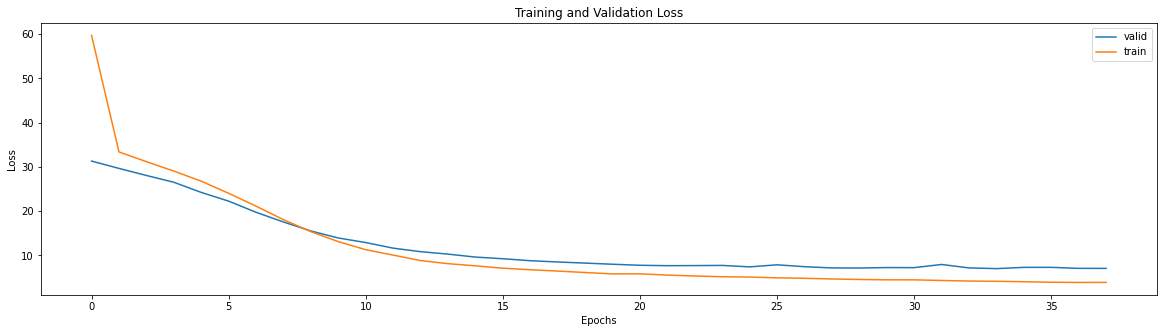

In [132]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [133]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o.squeeze(), y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 2.4765


In [134]:
# R square
o=model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())

tensor(0.7974, device='cuda:0', grad_fn=<RsubBackward1>)

In [65]:
#

In [141]:
class E2EBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, bias=False):
        super(E2EBlock, self).__init__()
        self.cnn1 = torch.nn.Conv2d(in_dim, out_dim, (1, 27), bias=bias)
        self.cnn2 = torch.nn.Conv2d(in_dim, out_dim, (27, 1), bias=bias)

        #nn.init.xavier_uniform_(self.cnn2.weight)

    def forward(self, x):
        a = self.cnn1(x)
        b = self.cnn2(x)

        return torch.cat([a]*27, 3) + torch.cat([b]*27, 2)

class BrainNetCNN(torch.nn.Module):
    def __init__(self):
        super(BrainNetCNN, self).__init__()
        
        self.e2econv1 = E2EBlock(1, 8, bias=True)
        #self.conv5_bn = nn.BatchNorm2d(256)

        self.E2N = torch.nn.Conv2d(8, 1, (1, 27))
        self.N2G = torch.nn.Conv2d(1, 128, (27, 1))

        self.fc1 = torch.nn.Linear(128, 64)
        self.fc2 = torch.nn.Linear(64, 1)
        #self.dense5 = torch.nn.Linear(16, 3)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.e2econv1(x))
        #out = self.conv5_bn(out)
        #out = F.max_pool2d(out, 2)  # 적용한 마지막 output kernel size, kernel 영향 + 풀링 영향으로 줄어든 사이즈

        x = F.relu(self.E2N(x))
        x = F.relu(self.N2G(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        #x = self.dense4_bn(x)

        return x

def weights_init(m):
    #if isinstance(m, nn.Conv2d):
    #    nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #m.bias.data[0] = 9.0844
        
        #if m.bias is not None:
        #  nn.init.constant_(m.bias.data, 10)
        #nn.init.xavier_normal_(m.bias.data)

torch.manual_seed(42)
model = BrainNetCNN().cuda()
model.apply(weights_init)
print(model)

BrainNetCNN(
  (e2econv1): E2EBlock(
    (cnn1): Conv2d(1, 8, kernel_size=(1, 27), stride=(1, 1))
    (cnn2): Conv2d(1, 8, kernel_size=(27, 1), stride=(1, 1))
  )
  (E2N): Conv2d(8, 1, kernel_size=(1, 27), stride=(1, 1))
  (N2G): Conv2d(1, 128, kernel_size=(27, 1), stride=(1, 1))
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


In [142]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

12570

In [161]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)#5e-6
loss_function = nn.MSELoss()
epochs = 1

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 3.8156
====> Test set loss: 7.1315
====> Test set loss: 7.1315


In [162]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o.squeeze(), y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 2.4952


In [163]:
# R square
o = model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())

tensor(0.7950, device='cuda:0', grad_fn=<RsubBackward1>)

In [164]:
#

In [131]:
class E2EBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, bias=False):
        super(E2EBlock, self).__init__()
        self.cnn1 = torch.nn.Conv2d(in_dim, out_dim, (1, 27), bias=bias)
        self.cnn2 = torch.nn.Conv2d(in_dim, out_dim, (27, 1), bias=bias)

        #nn.init.xavier_uniform_(self.cnn2.weight)

    def forward(self, x):
        a = self.cnn1(x)
        b = self.cnn2(x)

        return torch.cat([a]*27, 3) + torch.cat([b]*27, 2)

class BrainNetCNN(torch.nn.Module):
    def __init__(self):
        super(BrainNetCNN, self).__init__()
        
        self.e2econv1 = E2EBlock(1, 8, bias=True)
        #self.conv5_bn = nn.BatchNorm2d(256)

        self.E2N = torch.nn.Conv2d(8, 1, (1, 27))
        self.N2G = torch.nn.Conv2d(1, 16, (27, 1))

        self.fc1 = torch.nn.Linear(16, 8)
        self.fc2 = torch.nn.Linear(8, 4)
        self.fc3 = torch.nn.Linear(4, 2)
        self.fc4 = torch.nn.Linear(2, 2)
        self.fc5 = torch.nn.Linear(2, 1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.e2econv1(x))
        #out = self.conv5_bn(out)
        #out = F.max_pool2d(out, 2)  # 적용한 마지막 output kernel size, kernel 영향 + 풀링 영향으로 줄어든 사이즈

        x = F.relu(self.E2N(x))
        x = F.relu(self.N2G(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        #x = self.dense4_bn(x)

        return x

def weights_init(m):
    #if isinstance(m, nn.Conv2d):
    #    nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data, nn.init.calculate_gain('relu'))
        #m.bias.data[0] = 9.0844
        
        #if m.bias is not None:
        #  nn.init.constant_(m.bias.data, 10)
        #nn.init.xavier_normal_(m.bias.data)

torch.manual_seed(42)
model = BrainNetCNN().cuda()
model.apply(weights_init)
print(model)

BrainNetCNN(
  (e2econv1): E2EBlock(
    (cnn1): Conv2d(1, 8, kernel_size=(1, 27), stride=(1, 1))
    (cnn2): Conv2d(1, 8, kernel_size=(27, 1), stride=(1, 1))
  )
  (E2N): Conv2d(8, 1, kernel_size=(1, 27), stride=(1, 1))
  (N2G): Conv2d(1, 16, kernel_size=(27, 1), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=2, bias=True)
  (fc5): Linear(in_features=2, out_features=1, bias=True)
)


In [132]:
# the number of trainable parameter
sum(p.numel() for p in model.parameters() if p.requires_grad)

1304

In [133]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-3)#5e-6
loss_function = nn.MSELoss()
epochs = 100 #33 #37 #33 #28 #37 #51  

# for loss plot
tloss = []
vloss = []

for e in range(1, epochs+1):
    train(model, tloss, e)
    test(model, vloss)

y_pred = test_pred(model)

====> Epoch: 1 loss: 114.2715
====> Test set loss: 110.4504
====> Epoch: 2 loss: 107.9020
====> Test set loss: 104.1856
====> Epoch: 3 loss: 101.9924
====> Test set loss: 98.3522
====> Epoch: 4 loss: 96.4345
====> Test set loss: 92.8169
====> Epoch: 5 loss: 91.2231
====> Test set loss: 87.6600
====> Epoch: 6 loss: 86.3654
====> Test set loss: 82.8486
====> Epoch: 7 loss: 81.8202
====> Test set loss: 78.3557
====> Epoch: 8 loss: 77.5770
====> Test set loss: 74.1175
====> Epoch: 9 loss: 73.6050
====> Test set loss: 70.1863
====> Epoch: 10 loss: 69.9087
====> Test set loss: 66.5144
====> Epoch: 11 loss: 66.4872
====> Test set loss: 63.0936
====> Epoch: 12 loss: 63.3223
====> Test set loss: 59.9670
====> Epoch: 13 loss: 60.4224
====> Test set loss: 57.0837
====> Epoch: 14 loss: 57.7447
====> Test set loss: 54.4244
====> Epoch: 15 loss: 55.2878
====> Test set loss: 51.9822
====> Epoch: 16 loss: 53.0515
====> Test set loss: 49.7479
====> Epoch: 17 loss: 51.0250
====> Test set loss: 47.7276
=

In [122]:
np.argmin(vloss) + 1

64

In [134]:
# RMSE

model.eval()
test_loss = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda().float(), y.cuda()       
        o = model(x)
        loss = torch.sqrt(loss_function(o.squeeze(), y))
        
        test_loss += loss.item()
print('====> Test set loss: {:.4f}'.format(test_loss / len(test_loader)))

====> Test set loss: 5.5550


In [135]:
# R square
o = model(x_val.cuda())
r2(o.squeeze(), y_val.cuda())

tensor(-0.0009, device='cuda:0', grad_fn=<RsubBackward1>)

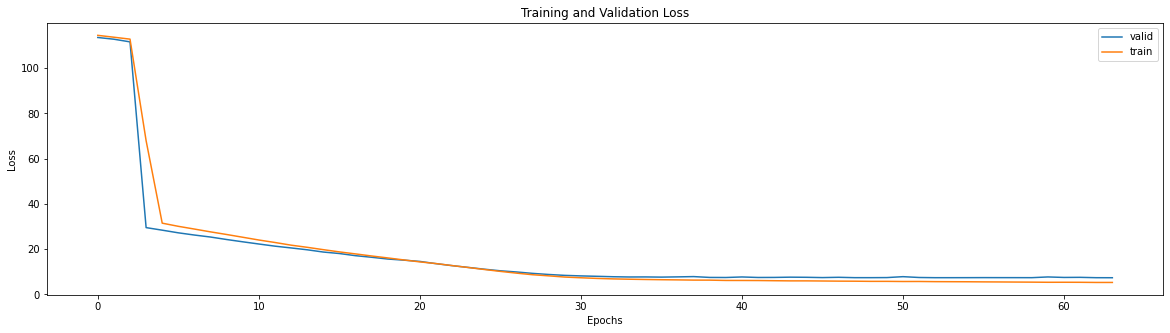

In [130]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.title("Training and Validation Loss")
plt.plot(np.array(vloss), label="valid")
plt.plot(np.array(tloss), label="train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()